# 2. Data Modeling: CNN model

version colab

## Environment Setup

## TPU backend

In [ ]:
# Enabling and testing the TPU
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


# install scikit-plot to Colab
!pip install scikit-plot

Tensorflow version 2.6.0
Running on TPU  ['10.40.249.82:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.40.249.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.249.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# libraries import
import os # miscellaneous operating system interfaces
import numpy as np # Array library for linear algebra
import matplotlib.pyplot as plt # visualization library
from sklearn.metrics import classification_report # evaluators classification report
import scikitplot as skplt # scikit-learn and matplotlib integrated visualization library
from tensorflow import keras # back-end artificial neural network API
from tensorflow.keras import layers # layer API for neural network architechture
from tensorflow.keras.optimizers import Adam # optimizer in neural network implement
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving
from keras.models import model_from_json # loading model in JSON format

# system configuration
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0" # disable warning messages
os.environ['AUTOGRAPH_VERBOSITY'] = '0' # set it to 0
random_seed = 20 # random seed

print('\n')
print('necessary libraries has successfully imported')



necessary libraries has successfully imported


In [ ]:
# connect to google drive to obtain dataset
# !note: need to perform authorization by following below link
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define model name
modelName = 'CNN'

print(modelName, 'modeling is initializing')
print('\n')

CNN modeling is initializing


## Data Loading

In [ ]:
# define path to files
defaultdir = '/content/drive/My Drive/all_about_phd_research/'

In [ ]:
print('loading processed data')
print('\n')

# load input data from drive
X_train = np.load(defaultdir + '/processed_data/X_train.npy')
X_test = np.load(defaultdir + '/processed_data/X_test.npy')
y_train = np.load(defaultdir + '/processed_data/y_train.npy')
y_test = np.load(defaultdir + '/processed_data/y_test.npy')

print('loading done')
print('\n')

loading processed data
loading done


## Data Modeling

In [ ]:
# define function to create CNN model
def cnnModel(data_train, num_classes, layer=1, x_filter= 64, 
             kernel_size= (3,3), pool_size=(2,2), drop_size=0.5, 
             ):
    
    # input layer convert arrays => tensors
    inputs = keras.Input(data_train.shape[1:]) # dimension of the input

    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(inputs)
    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(x1)
    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
    x1 = layers.Dropout(drop_size)(x1)
    
    dense_size = x_filter
    
    if layer > 1:
        
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
        x1 = layers.Dropout(drop_size)(x1)
        
        dense_size = 2*x_filter
        
        if layer > 2:

            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
            x1 = layers.Dropout(drop_size)(x1)
            
            dense_size = 4*x_filter
            
            if layer > 3:

                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                x1 = layers.Dropout(drop_size)(x1)
                
                dense_size = 8*x_filter
                
                if layer > 4:

                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                    x1 = layers.Dropout(drop_size)(x1)
                    
                    dense_size = 8*x_filter

    x2 = layers.Flatten()(x1)
    x2 = layers.Dense(dense_size, activation = "relu")(x2)

    outputs = layers.Dense(num_classes, activation= "softmax")(x2)

    cnnModel = keras.Model(inputs=inputs, outputs=outputs, name="cnnModel")

    cnnModel.summary()
    
    return cnnModel

In [ ]:
# perform CNN model define function
cnnModel = cnnModel(X_train, layer=2, num_classes=3)

print('\n')
print(modelName, 'model contruction done')
print('\n')

Model: "cnnModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 330, 640, 224)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 330, 640, 64)      129088    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 330, 640, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 165, 320, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 165, 320, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 165, 320, 128)     73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 165, 320, 128)     147

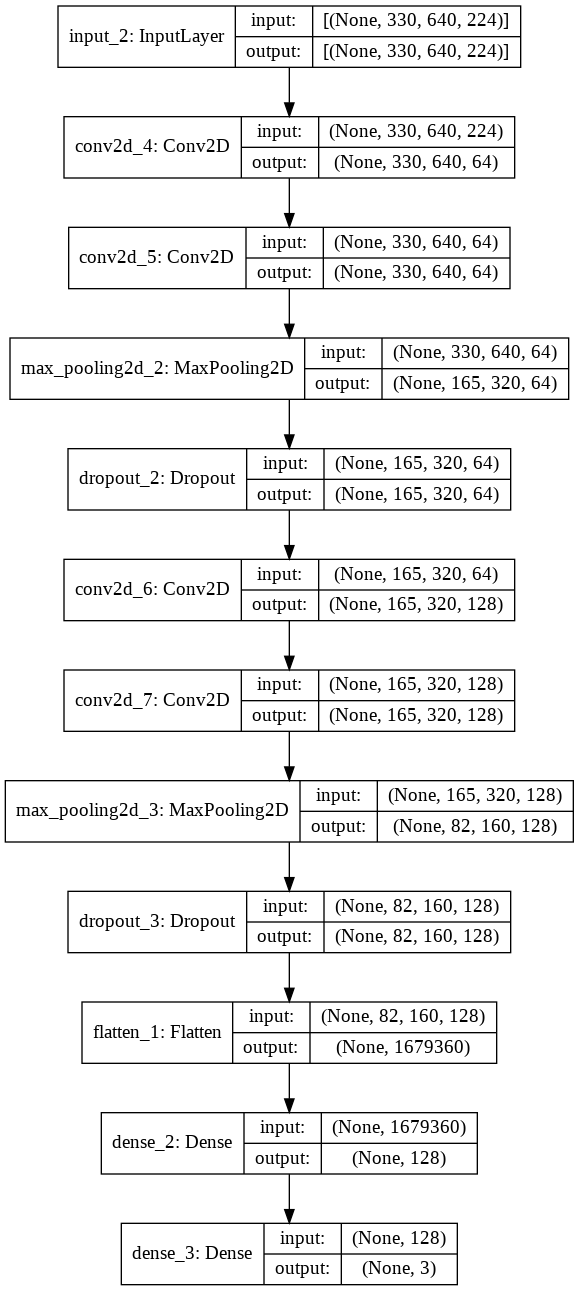

In [ ]:
# plot CNN model architecture
# the figure will be saved in the same directory with input datas
tf.keras.utils.plot_model(cnnModel, 
                          to_file=defaultdir + '/processed_data/{}_model_architecture.png'.format(modelName), 
                          show_shapes=True)

In [ ]:
# define ADAM opimizer & complie resulting in ready-to-train model function
def modelComplie(cnnModel, X_train, y_train, 
             X_test, y_test,
             epochs, batch_size, 
             learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
             epsilon=1e-08, decay=0):

  # Define the optimizer
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, 
                   epsilon=epsilon, decay=decay)

  # assign metrics for the model
  cnnModel.compile(optimizer=optimizer , 
                   loss="categorical_crossentropy", 
                   metrics=["accuracy"])

## Model Training

In [ ]:
# define training epoch number & batch size  parameters
epochs_list = [5]
batch_size_list = [5]

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                          patience=3, 
                                          verbose=1, 
                                          factor=0.5, 
                                          min_lr=0.00001)
  
# loop for training model
for epochs in epochs_list:
  for batch_size in batch_size_list:

    # perform compile model function
    modelComplie(cnnModel=cnnModel, X_train=X_train, y_train=y_train, 
         X_test=X_test, y_test=y_test, 
         epochs=epochs, batch_size=batch_size)
    
    print('\n')
    print(modelName, 'model is training in total =', epochs, 'epochs')
    print('In each epoch has batch size =', batch_size, 'samples')
    print('\n')
    
    
    # training model with learning rate annealer
    history = cnnModel.fit(X_train, y_train, 
                         batch_size=batch_size,
                         epochs = epochs, 
                         validation_data = (X_test,y_test),
                         verbose = 1, 
                         steps_per_epoch=X_train.shape[0]//batch_size,
                         callbacks=[learning_rate_reduction])
    
    print('\n')
    print(modelName,'model training has done')
    print('\n')



CNN model is training in total = 5 epochs
In each epoch has batch size = 5 samples


Epoch 1/5
3/3 [==============================] - 24s 9s/step - loss: 492.5244 - accuracy: 0.2667 - val_loss: 18.8204 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 11s 4s/step - loss: 25.3019 - accuracy: 0.3333 - val_loss: 1.1336 - val_accuracy: 0.1667
Epoch 3/5
3/3 [==============================] - 10s 3s/step - loss: 0.9509 - accuracy: 0.5833 - val_loss: 1.0777 - val_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 11s 3s/step - loss: 1.0137 - accuracy: 0.5833 - val_loss: 1.0594 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/5
3/3 [==============================] - 12s 4s/step - loss: 0.8990 - accuracy: 0.7333 - val_loss: 1.0689 - val_accuracy: 0.5000


CNN model has done training




## Model Prediction
### Note:
At this stage, we have 5 datasets and 1 model which are
1. X_train: training dataset
2. X_test: testing dataset
3. y_train: training label
4. y_test: testing label
5. y_pred: prediction label from model
6. cnnModel: CNN model

In [ ]:
# making predictions
print(modelName, 'model making prediction')
print('\n')

y_pred = cnnModel.predict(X_test, verbose=1)

print('\n')
print(modelName, 'model making prediction has done')
print('\n')

CNN model making prediction


1/1 [==============================] - 7s 7s/step


CNN model making prediction has done




# Model Evaluation

In [ ]:
print(modelName, 'model evaluation is now processing')
print('\n')

CNN model evaluation is process




loss & accuracy plot




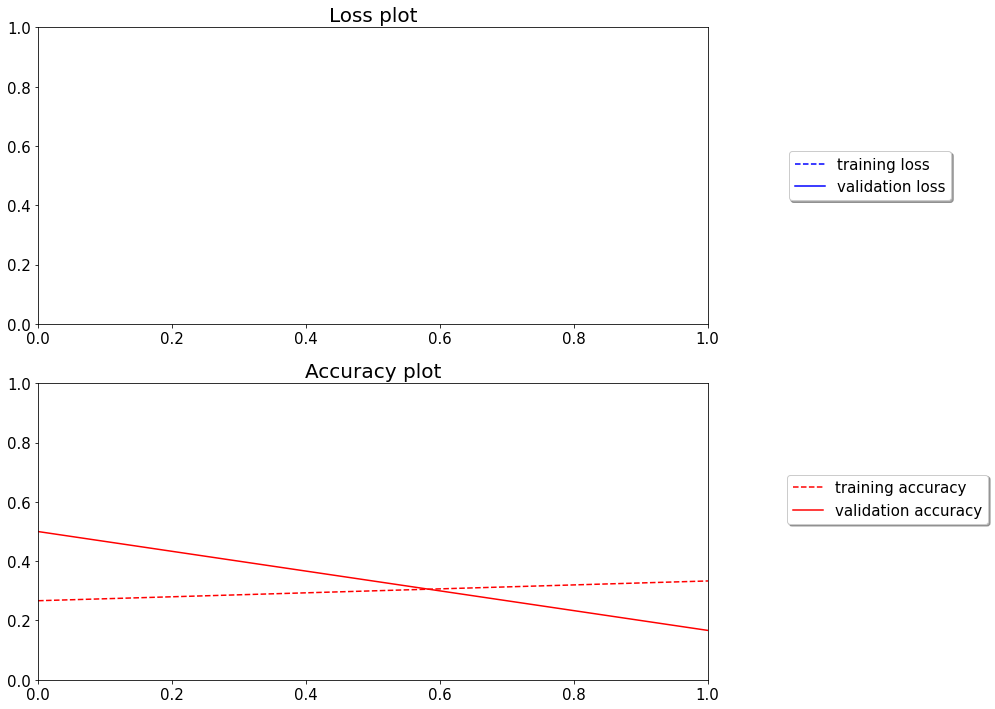

In [ ]:
print('loss & accuracy plot')
print('\n')

# Plot the loss & accuracy curves for training and validation
# Define number of plots -> 2
figurename = 'Loss and Accuracy plot of {} model'.format(modelName)

plt.figure(figsize=(12,12))
plt.tight_layout()

# set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# -------------------------------------------------------------------------------------------------------------------------------
# Loss plot
plt.subplot(2,1,1)
plt.plot(history.history['loss'], '--', color='b', label="training loss")
plt.plot(history.history['val_loss'], '-', color='b', label="validation loss")

# decorating
plt.axis([0, 1, 0, 1]) # define lower & upper boundaries of axes ([x-axis, y-axis])
legend = plt.legend(loc='center right', shadow=True, bbox_to_anchor=(1.375, 0.5), ncol=1,fontsize=MEDIUM_SIZE)
plt.title('Loss plot', fontsize=BIGGER_SIZE)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

# -------------------------------------------------------------------------------------------------------------------------------
# Accuracy plot
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], '--', color='r', label="training accuracy")
plt.plot(history.history['val_accuracy'], '-', color='r',label="validation accuracy")

# decorating
plt.axis([0, 1, 0, 1]) # define lower & upper boundaries of axes ([x-axis, y-axis])
legend = plt.legend(loc='lower right', shadow=True, bbox_to_anchor=(1.43, 0.5), ncol=1, fontsize=MEDIUM_SIZE)
plt.title('Accuracy plot', fontsize=BIGGER_SIZE)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

# plt.subplots_adjust(hspace=0.5)

# save figure
plt.savefig(defaultdir + '/processed_data/' + figurename + '.png')

## Confusion matrix and AUC-ROC curve

In [ ]:
# def plot confusion matrix function
def plotConfusionMatrix(y_test=y_test, y_pred=y_pred, cmap=plt.cm.Reds, title='Confusion Matrix of {} model'.format(modelName)):

  # set font sizes
  SMALL_SIZE = 12
  MEDIUM_SIZE = 15
  BIGGER_SIZE = 20

  skplt.metrics.plot_confusion_matrix(y_true=np.argmax(y_test, axis=1), 
                                      y_pred=np.argmax(y_pred, axis=1), 
                                      title=title, 
                                      normalize='true', 
                                      figsize=(9,9), 
                                      cmap=cmap, 
                                      title_fontsize= BIGGER_SIZE, 
                                      text_fontsize= BIGGER_SIZE
                                      )

  # save figure
  plt.savefig(defaultdir + '/processed_data/' + title + '.png')

confusion matrix plot




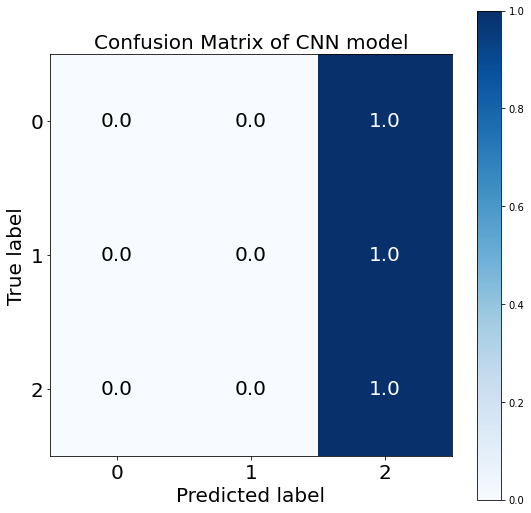

In [ ]:
print('confusion matrix plot')
print('\n')

# perform plot confusion matrix function
title = 'Confusion Matrix of {} model'.format(modelName)
plot = plotConfusionMatrix(y_test=y_test, y_pred=y_pred, cmap=plt.cm.Purples, title=title)

In [ ]:
# def plot ROC curve function
def plotROC(y_test=y_test, y_pred=y_pred, cmap=plt.cm.Reds, title='ROC curve of {} model'.format(modelName)):

  # set font sizes
  SMALL_SIZE = 12
  MEDIUM_SIZE = 15
  BIGGER_SIZE = 20

  skplt.metrics.plot_roc(y_true=np.argmax(y_test, axis=1), 
                                      y_probas=y_pred, 
                                      title=title, 
                                      plot_micro=True, 
                                      plot_macro=True, 
                                      figsize=(12,6), 
                                      cmap=cmap, 
                                      title_fontsize= BIGGER_SIZE, 
                                      text_fontsize= MEDIUM_SIZE
                         )

  # save figure
  plt.savefig(defaultdir + '/processed_data/' + title + '.png')

AUC-ROC curve plot




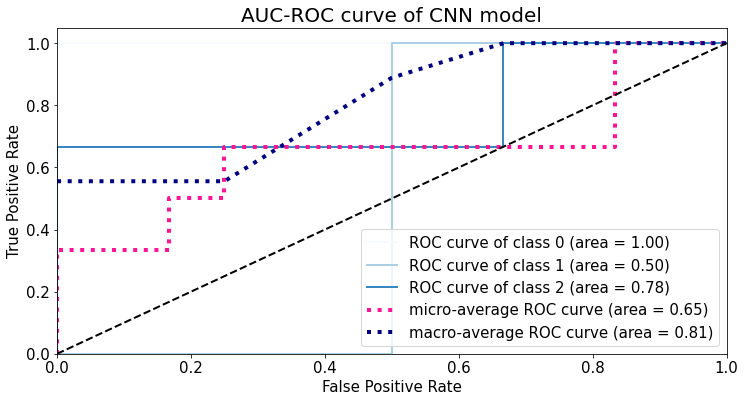

In [ ]:
print('AUC-ROC curve plot')
print('\n')

# perform plot AUC-ROC curve function
title = 'AUC-ROC curve of {} model'.format(modelName)
plot = plotROC(y_test=y_test, y_pred=y_pred, cmap=plt.cm.Purples, title=title)

## Print Classification Report

In [ ]:
# classification report
num_classes = 3
class_list = ['class '+ str(y_class) for y_class in range(num_classes)]

print('classification report of {} model'.format(modelName))
print('\n')
print(classification_report(np.argmax(y_test,axis=1), 
                            np.argmax(y_pred,axis=1), 
                            target_names= class_list))

print('\n')

classification report of CNN model


              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         1
     class 1       0.00      0.00      0.00         2
     class 2       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.17      0.33      0.22         6
weighted avg       0.25      0.50      0.33         6



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving model

In [ ]:
# define saving function
def save_model (model, model_name):

    # serialize model to JSON
    model_json = model.to_json()
    
    with open("{}.json".format(defaultdir + '/processed_data/' + model_name), "w") as json_file:
        
        json_file.write(model_json)

        # serialize weights to HDF5
        model.save_weights("{}_weight.h5".format(defaultdir + '/processed_data/' + model_name))

    print("Saved {} to drive".format(model_name))

In [ ]:
# perform saving
save_model(model=cnnModel, model_name= modelName.lower() + 'Model')

Saved cnnModel to drive


## Load the saved model

In [ ]:
# define loading function
def load_model (model, model_name):

    # load json and create model
    json_file = open('{}.json'.format(defaultdir + '/processed_data/' + model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("{}_weight.h5".format(defaultdir + '/processed_data/' + model_name))
    print("Loaded {} from drive".format(model_name))
    
    return loaded_model

In [ ]:
# perform loading
cnnModel = load_model(model=cnnModel, model_name= modelName.lower() + 'Model')

Loaded cnnModel from drive


## Perform testing loaded model

In [ ]:
# perform compile model function
modelComplie(cnnModel=cnnModel, X_train=X_train, y_train=y_train, 
         X_test=X_test, y_test=y_test, 
         epochs=epochs, batch_size=batch_size)

# evaluate the loaded model
cnnModel.evaluate(X_train, y_train, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 1.1452 - accuracy: 0.3529


[1.1451706886291504, 0.3529411852359772]

In [ ]:
# making prediction of loaded model
cnnModel.predict(X_test, verbose=1)

1/1 [==============================] - 1s 866ms/step


array([[0.24847318, 0.19279516, 0.55873173],
       [0.24992771, 0.19079068, 0.5592815 ],
       [0.25052497, 0.18951626, 0.55995876],
       [0.25338352, 0.19242649, 0.55419   ],
       [0.25214538, 0.18304792, 0.56480676],
       [0.24615993, 0.18690804, 0.56693196]], dtype=float32)

In [ ]:
print('\n')
print(modelName, 'modeling process is completed')

CNN modeling process is completed


# Finish Data life cycle